# Data Augmentation

## 本章節大綱
* [讀取資料](#讀取資料)
* [建立模型並訓練](#建立模型並訓練)
* [亮度 Brightness](#亮度-Brightness)
* [色調 Hue](#色調-Hue)
* [飽和度 Saturation](#飽和度-Saturation)
* [品質 Quality](品質-Quality)
* [翻轉 Flip](翻轉-Flip)
* [旋轉 Rotation](#旋轉-Rotation)
* [裁剪 Crop](#裁剪-Crop)
* [隨機 Zoom](#縮放-Zoom)
* [隨機高度 RandomHeight](#隨機高度-RandomHeight)
* [隨機寬度 RandomWidth](#隨機寬度-RandomWidth)
* [隨機平移 RandomTranslation](#隨機平移-RandomTranslation)
* [綜合](#整合)

* ## 讀取資料


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras import layers

In [56]:
# 下載課程所需檔案
!wget -q "https://github.com/TA-aiacademy/course_3.0/releases/download/CVCNN_Data/cnn_part2_data.zip"
!unzip -q cnn_part2_data.zip
!wget -q "https://github.com/TA-aiacademy/course_3.0/releases/download/CVCNN_Data/cat_dog.zip"
!unzip -q cat_dog.zip

In [2]:
# 讀取訓練資料的 csv
datalist = pd.read_csv("./data/cat_dog_df.csv", index_col=False) 

In [3]:
datalist

file_name  type
0       /datasets/aia-data/cat_dog/train/cat.8852.jpg     0
1      /datasets/aia-data/cat_dog/train/cat.11428.jpg     0
2      /datasets/aia-data/cat_dog/train/cat.12315.jpg     0
3       /datasets/aia-data/cat_dog/train/dog.4577.jpg     1
4       /datasets/aia-data/cat_dog/train/cat.3228.jpg     0
...                                               ...   ...
24995   /datasets/aia-data/cat_dog/train/cat.4214.jpg     0
24996   /datasets/aia-data/cat_dog/train/dog.4524.jpg     1
24997    /datasets/aia-data/cat_dog/train/cat.911.jpg     0
24998  /datasets/aia-data/cat_dog/train/cat.11755.jpg     0
24999   /datasets/aia-data/cat_dog/train/cat.1353.jpg     0

[25000 rows x 2 columns]

In [4]:
import random
def my_preprocess(image):
    image = cv2.resize(image, (256, 256))
    return image
def data_generater() :
    datalist = pd.read_csv("./data/cat_dog_df.csv", index_col=False) 
    # 打亂資料順序
    data = list(zip(datalist['file_name'],
                    datalist['type']))
    random.shuffle(data)
    # 讀取 data 中的資料，將路徑中的圖片一張一張讀取
    for path, label in data:
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)# BGR2RGB 
        image = my_preprocess(image)
        yield image, [1, 0] if label == 0 else [0, 1]

In [5]:
# 使用 tf.data.Dataset 製造一個 Dataset
# output_signature : 輸出的格式
dataset = tf.data.Dataset.from_generator(data_generater,
                                         output_signature=( 
                                             tf.TensorSpec(shape=(256,256,3), dtype=tf.float32),
                                             tf.TensorSpec(shape=(2), dtype=tf.float32)))

2023-03-08 16:19:12.627952: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 16:19:13.288525: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10417 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1


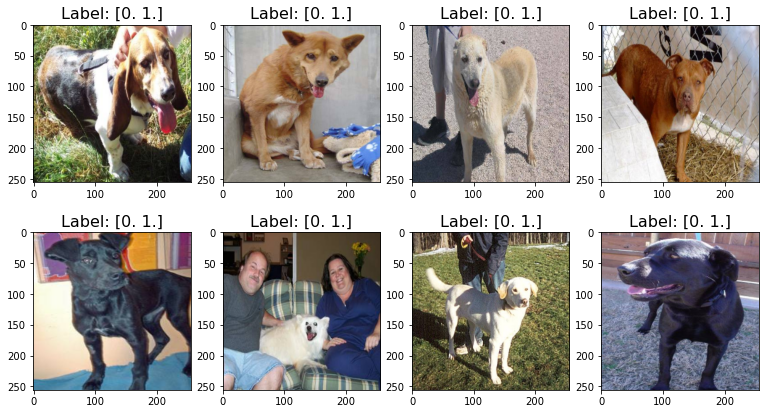

In [6]:
# 畫圖
def my_plot(datas):
    plt.figure(figsize=(13, 7))
    for i,data in enumerate(datas):
        plt.subplot(2, 4, i+1)
        plt.imshow(data[0].numpy().astype('uint8'))
        plt.title("Label: {}".format(data[1]), fontsize=16)
    plt.show()
my_plot(dataset.take(8))

* ## 建立模型並訓練


In [7]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Input, Dense, Dropout, Activation,
                                     BatchNormalization, Flatten,
                                     Conv2D, MaxPooling2D)

In [11]:
# 選擇 Keras 的 API 寫法
inputs = Input(shape=(256,256,3))

# 第一層
# 建立卷積層，設定32個3*3的filters
# 設定ReLU為激活函數。
x = Conv2D(32, (3, 3), activation='relu')(inputs)

# 第二層 - 卷積層 + 池化層
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# 第三層 - 卷積層
x = Conv2D(64, (3, 3), activation='relu')(x)

# 第四層 - 卷積層 + 池化層
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# 建立分類模型 (MLP) : 平坦層 + 輸出層 (10)
x = Flatten()(x)
outputs = Dense(2, activation='softmax')(x)


cnn_model = Model(inputs=inputs, outputs=outputs)
learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

cnn_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

In [19]:
# 將資料集批次存取
dataset_batch = dataset.batch(128).cache()

In [21]:
# 訓練時直接給 dataset 即可
cnn_model.fit(dataset_batch, epochs=2)

196/196 [==============================] - 127s 647ms/step - loss: 7.1594 - accuracy: 0.5606


---
# 資料擴增

## 圖像數值調整使用 tf.image
- 圖像調整：亮度、對比度、色調、飽和度、品質、翻轉

## 圖像形狀調整使用 tf.keras.layers
- 圖像旋轉：剪裁、翻轉、旋轉、縮放、高度、寬度
---

* ## 亮度 Brightness

 * max_delta：調整的幅度，0 ~ 1

In [22]:
def my_preprocess(image):
    image = cv2.resize(image, (256, 256))
    image = tf.image.random_brightness(image, 
                                       max_delta = 0.4)
    image = tf.cast(image, tf.uint8)
    return image

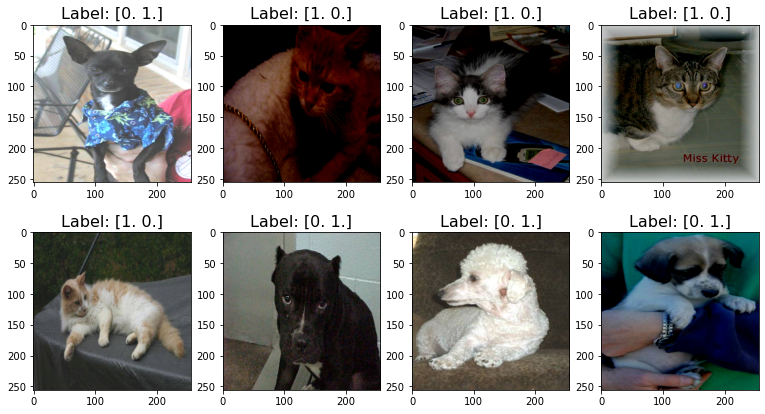

In [23]:
my_plot(dataset.take(8))

[(back...)](#本章節大綱)

* ## 對比度 Contrast

 * lower：對比下限，0 ~ 1
 * upper：對比上限，0 ~ 1

In [26]:
def my_preprocess(image):
    image = cv2.resize(image, (256, 256))
    image = tf.image.random_contrast(image,
                                     lower=0.2,
                                     upper=0.7)
    image = tf.cast(image, tf.uint8)
    return image

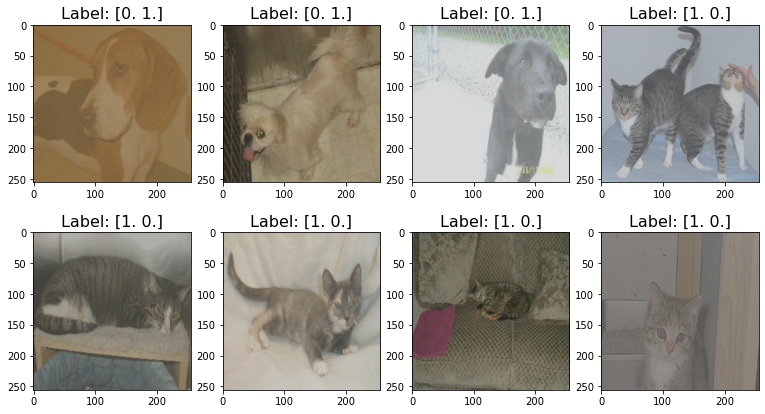

In [27]:
my_plot(dataset.take(8))

* ## 色調 Hue

 * max_delta：調整範圍，0 ~ 1

In [28]:
def my_preprocess(image):
    image = cv2.resize(image, (256, 256))
    image = tf.image.random_hue(image,
                                max_delta=0.4)
    image = tf.cast(image, tf.uint8)
    return image

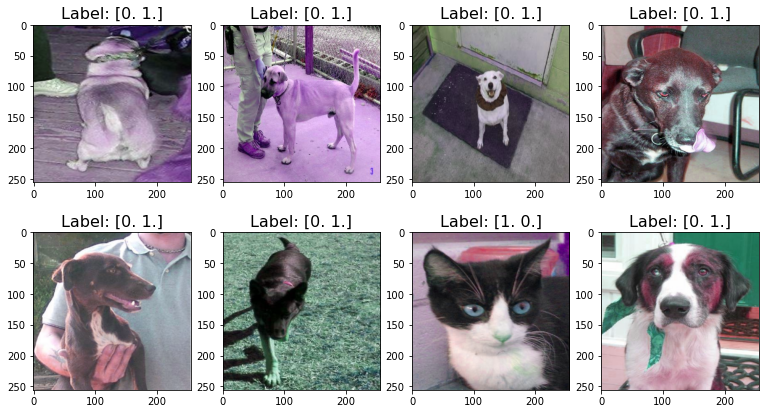

In [29]:
my_plot(dataset.take(8))

[(back...)](#本章節大綱)

* ## 飽和度 Saturation

 * lower：飽和度下限
 * upper：飽和度上限

In [30]:
def my_preprocess(image):
    image = cv2.resize(image, (256, 256))
    image = tf.image.random_saturation(image,
                                       lower=2,
                                       upper=5)
    image = tf.cast(image, tf.uint8)
    return image

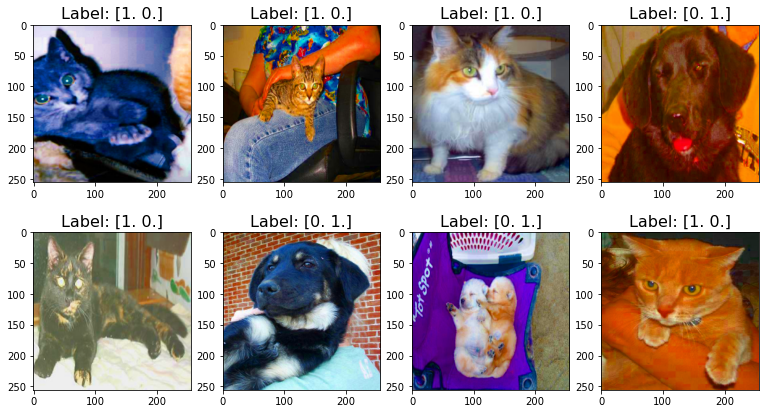

In [31]:
my_plot(dataset.take(8))

[(back...)](#本章節大綱)

* ## 品質 Quality
 * min_jpeg_quality：品質下限，0 ~ 100
 * max_jpeg_quality：品質上限，0 ~ 100

In [32]:
def my_preprocess(image):
    image = cv2.resize(image, (256, 256))
    image = tf.image.random_jpeg_quality(image,
                                         min_jpeg_quality=0,
                                         max_jpeg_quality=100)
    image = tf.cast(image, tf.uint8)
    return image

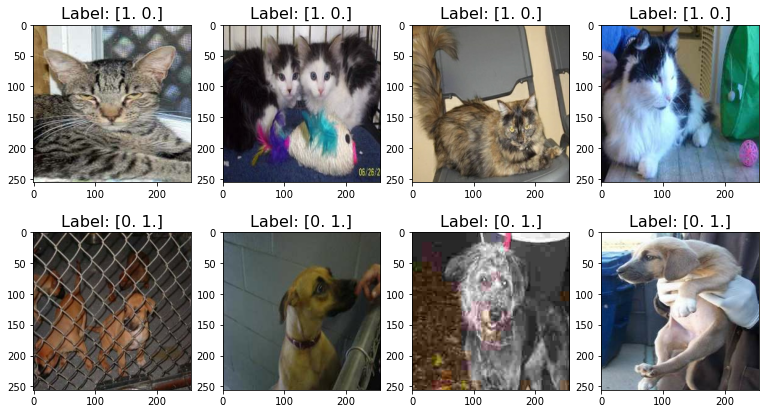

In [33]:
my_plot(dataset.take(8))

[(back...)](#本章節大綱)

* ## 翻轉 Flip

 * random_flip_left_right：隨機水平翻轉
 * random_flip_up_down：隨機垂直翻轉


In [34]:
def my_preprocess(image):
    image = cv2.resize(image, (256, 256))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.cast(image, tf.uint8)
    return image

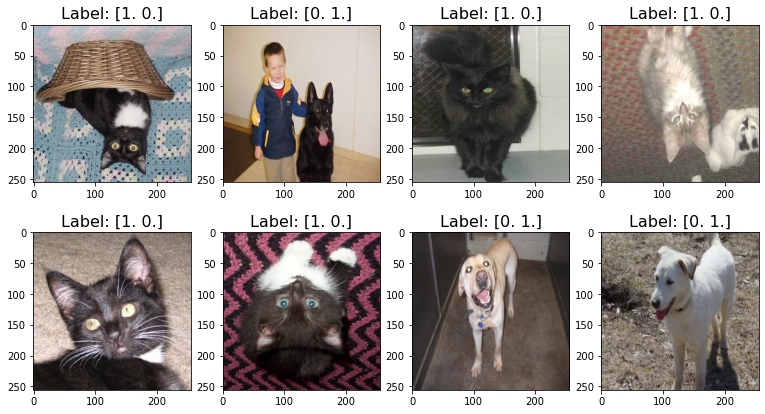

In [35]:
my_plot(dataset.take(8))

* ## 翻轉2 Flip

 * horizontal_and_vertical：隨機水平垂直翻轉
 * vertical：隨機垂直翻轉
 * horizontal：隨機水平翻轉


In [38]:
my_data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
    ]
)


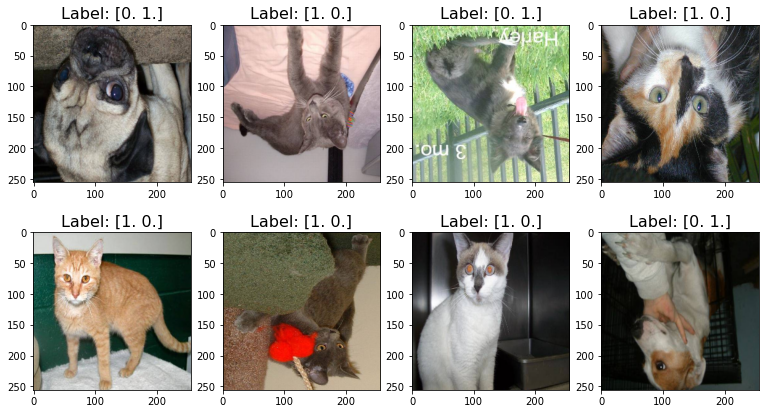

In [39]:
augment_dataset = dataset.map(lambda x, y: (my_data_augmentation(x), y))
my_plot(augment_dataset.take(8))

[(back...)](#本章節大綱)

* ## 旋轉 Rotation

 * factor 旋轉角度，(-0.2, 0.3) 代表從-20% * 2pi ~ 30% * 2pi 的區間縮放 
 * fill_mode：超過邊界填補方法，有 'nearest', 'constant', 'reflect', 'wrap'，四種方法可選擇 (default：'reflect')
 
    - reflect: (d c b a | a b c d | d c b a) The input is extended by reflecting about the edge of the last pixel.
    - constant: (k k k k | a b c d | k k k k) The input is extended by filling all values beyond the edge with the same constant value k = 0.
    - wrap: (a b c d | a b c d | a b c d) The input is extended by wrapping around to the opposite edge.
    - nearest: (a a a a | a b c d | d d d d) The input is extended by the nearest pixel.


In [40]:
my_data_augmentation = tf.keras.Sequential(
    [
        layers.RandomRotation(factor=(-0.3, 0.3),
                              fill_mode="reflect")
    ]
)

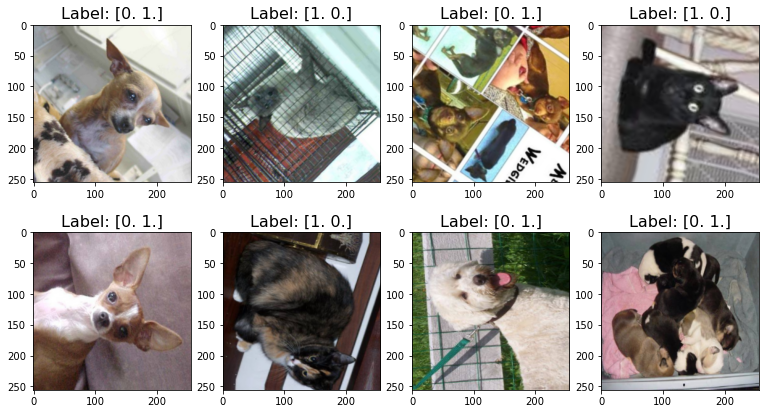

In [41]:
augment_dataset = dataset.map(lambda x, y: (my_data_augmentation(x), y))
my_plot(augment_dataset.take(8))

[(back...)](#本章節大綱)

* ## 裁剪 Crop

 * height：裁減高度 
 * width：裁減寬度


In [43]:
my_data_augmentation = tf.keras.Sequential(
    [
        layers.RandomCrop(height=100,
                          width=100)
    ]
)

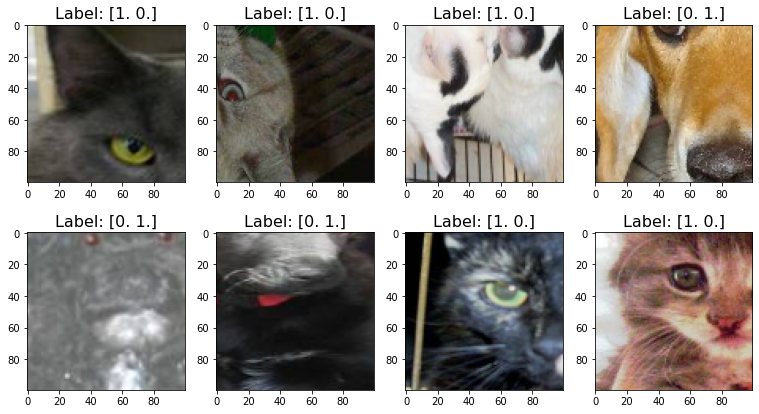

In [44]:
augment_dataset = dataset.map(lambda x, y: (my_data_augmentation(x), y))
my_plot(augment_dataset.take(8))

[(back...)](#本章節大綱)

* ## 縮放 Zoom
 * height_factor：高度調整比例，(-0.1, 0.1) 代表從-10% ~ 10%的區間縮放
 * width_factor：寬度調整比例，(-0.1, 0.1) 代表從-10% ~ 10%的區間縮放
 * fill_mode：超過邊界填補方法，有 'nearest', 'constant', 'reflect', 'wrap'，四種方法可選擇 (default：'reflect')
     - reflect: (d c b a | a b c d | d c b a) The input is extended by reflecting about the edge of the last pixel.
     - constant: (k k k k | a b c d | k k k k) The input is extended by filling all values beyond the edge with the same constant value k = 0.
     - wrap: (a b c d | a b c d | a b c d) The input is extended by wrapping around to the opposite edge.
     - nearest: (a a a a | a b c d | d d d d) The input is extended by the nearest pixel.

In [45]:
my_data_augmentation = tf.keras.Sequential(
    [
        layers.RandomZoom(height_factor=(-0.5, 0.5),
                          width_factor=(-0.5, 0.5),
                          fill_mode="nearest")                          
    ]
)

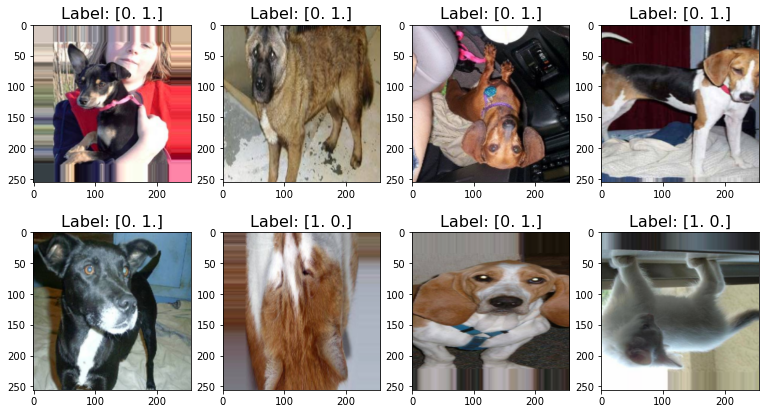

In [46]:
augment_dataset = dataset.map(lambda x, y: (my_data_augmentation(x), y))
my_plot(augment_dataset.take(8))

[(back...)](#本章節大綱)

* ## 隨機高度 RandomHeight

 * factor：調整比例，(-0.1, 0.1) 代表從-10% ~ 10%的區間縮放
 * interpolation：填補方法


In [47]:
my_data_augmentation = tf.keras.Sequential(
    [
        layers.RandomHeight(factor=(-0.8, 0.8),
                            interpolation='bilinear')
    ]
)

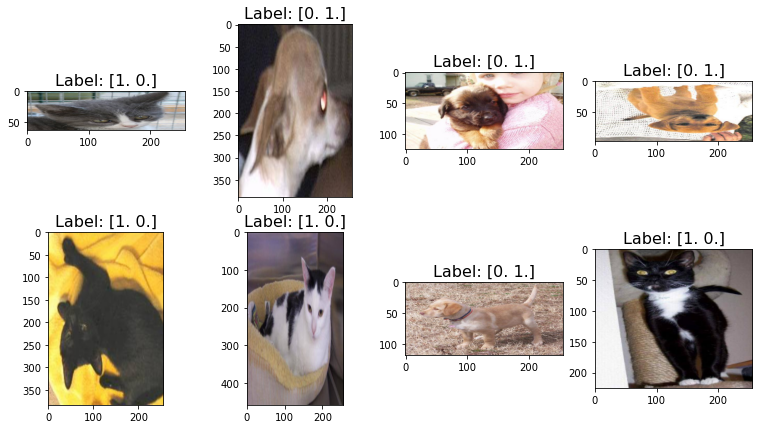

In [48]:
augment_dataset = dataset.map(lambda x, y: (my_data_augmentation(x), y))
my_plot(augment_dataset.take(8))

[(back...)](#本章節大綱)

* ## 隨機寬度 RandomWidth

 * factor：調整比例，(-0.1, 0.1) 代表從-10% ~ 10%的區間縮放


In [49]:
my_data_augmentation = tf.keras.Sequential(
    [
        layers.RandomWidth(factor=(-0.8, 0.8),
                            interpolation='bilinear')
    ]
)

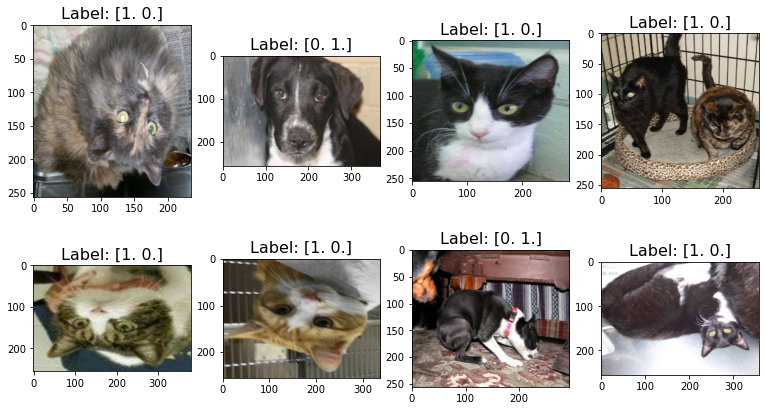

In [50]:
augment_dataset = dataset.map(lambda x, y: (my_data_augmentation(x), y))
my_plot(augment_dataset.take(8))

[(back...)](#本章節大綱)

* ## 隨機平移 RandomTranslation
 * height_factor：高度調整比例，(-0.1, 0.1) 代表從-10% ~ 10%的區間平移
 * width_factor：寬度調整比例，(-0.1, 0.1) 代表從-10% ~ 10%的區間平移
 * fill_mode：超過邊界填補方法，有 'nearest', 'constant', 'reflect', 'wrap'，四種方法可選擇 (default：'reflect')
     - reflect: (d c b a | a b c d | d c b a) The input is extended by reflecting about the edge of the last pixel.
     - constant: (k k k k | a b c d | k k k k) The input is extended by filling all values beyond the edge with the same constant value k = 0.
     - wrap: (a b c d | a b c d | a b c d) The input is extended by wrapping around to the opposite edge.
     - nearest: (a a a a | a b c d | d d d d) The input is extended by the nearest pixel.

In [51]:
my_data_augmentation = tf.keras.Sequential(
    [
        layers.RandomTranslation(height_factor=(-0.3, 0.3),
                                 width_factor=(-0.3, 0.3),
                                 fill_mode="reflect")
    ]
)

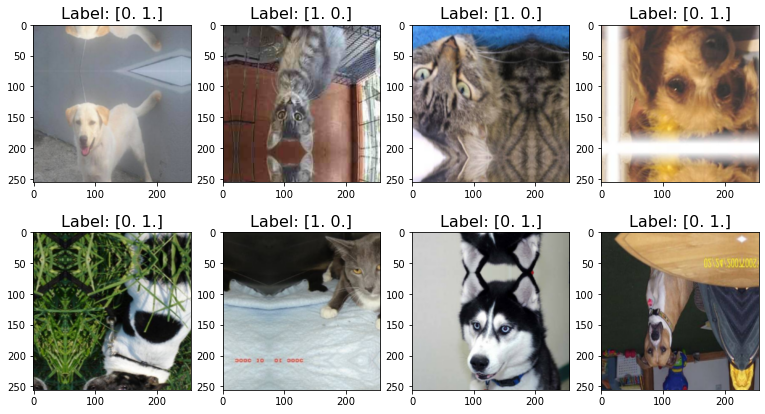

In [52]:
augment_dataset = dataset.map(lambda x, y: (my_data_augmentation(x), y))
my_plot(augment_dataset.take(8))

[(back...)](#本章節大綱)

# 整合

In [53]:
def my_preprocess(image):
    image = cv2.resize(image, (256, 256))
    # 亮度
    image = tf.image.random_brightness(image, 
                                       max_delta=0.2)
    # 對比度
    image = tf.image.random_contrast(image,
                                     lower=0.5,
                                     upper=1)
    # 色調
    image = tf.image.random_hue(image,
                                max_delta=0.4)
    # 飽和度
    image = tf.image.random_saturation(image,
                                       lower=1,
                                       upper=5)
    # 品質
    image = tf.image.random_jpeg_quality(image,
                                         min_jpeg_quality=20,
                                         max_jpeg_quality=100)
    image = tf.cast(image, tf.uint8)
    return image

In [54]:
my_data_augmentation = tf.keras.Sequential(
    [
        # 旋轉
        layers.RandomFlip("horizontal_and_vertical"),
        # 裁剪
        layers.RandomCrop(height = 230,
                          width = 230),
        # 隨機高度
        layers.RandomHeight(factor = (-0.3, 0.3),
                            interpolation = 'bilinear'),
        # 隨機寬度
        layers.RandomWidth(factor = (-0.3, 0.3),
                            interpolation = 'bilinear'),
        # 隨機縮放
        layers.RandomZoom(height_factor = (-0.3, 0.3),
                          width_factor = (-0.3, 0.3),
                          fill_mode = "nearest"),
        # 隨機平移
        layers.RandomTranslation(height_factor = (-0.3, 0.3),
                          width_factor = (-0.3, 0.3),
                          fill_mode = "reflect"),           
    ]
)

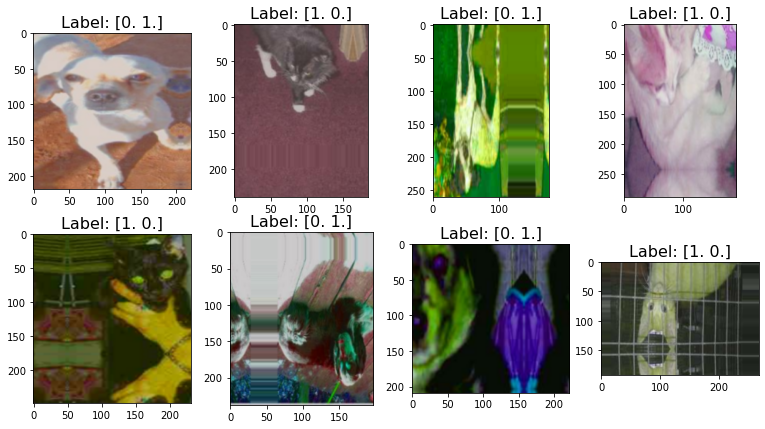

In [55]:
augment_dataset = dataset.map(lambda x, y: (my_data_augmentation(x), y))
my_plot(augment_dataset.take(8))

[(back...)](#本章節大綱)